# Ансамбли моделей машинного обучения.

Цель лабораторной работы: изучение ансамблей моделей машинного обучения.



### Задание:

- Выберите набор данных (датасет) для решения задачи классификации или регресии.
- В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
- С использованием метода train_test_split разделите выборку на обучающую и тестовую.
- Обучите две ансамблевые модели. Оцените качество моделей с помощью одной из подходящих для задачи метрик. Сравните качество полученных моделей.

In [1]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats
from IPython.display import Image
from io import StringIO 
from IPython.display import Image
import graphviz 
import pydotplus
from sklearn.datasets import load_iris, load_boston
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

In [2]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #Можно проверить все ли метки классов предсказываются
    #print(np.unique(Z))
    out = ax.contourf(xx, yy, Z, **params)
    return out


def plot_cl(clf):
    title = clf.__repr__
    clf.fit(iris_X, iris_y)
    fig, ax = plt.subplots(figsize=(5,5))
    X0, X1 = iris_X[:, 0], iris_X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=iris_y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    plt.show()

In [3]:
from operator import itemgetter

def draw_feature_importances(tree_model, X_dataset, figsize=(10,5)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

In [4]:
# Визуализация дерева
def get_png_tree(tree_model_param, feature_names_param):
    dot_data = StringIO()
    export_graphviz(tree_model_param, out_file=dot_data, feature_names=feature_names_param,
                    filled=True, rounded=True, special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph.create_png()

In [5]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

#### BaggingClassifier

In [6]:
# Используем датасет iris с двумя первыми признаками
iris = load_iris()
iris_X = iris.data[:, :2]
iris_y = iris.target

In [7]:
# Обучим классификатор на 5 деревьях
bc1 = BaggingClassifier(n_estimators=5, oob_score=True, random_state=10)
bc1.fit(iris_X, iris_y)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py:638: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py:642: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = (predictions /


BaggingClassifier(n_estimators=5, oob_score=True, random_state=10)

In [8]:
# Какие объекты были использованы в обучающей выборке каждого дерева
bc1.estimators_samples_

[array([137, 103, 142, 138,  26, 138,  50, 126,  67,  34,  24,  43, 149,
         58, 112, 118, 104,  46, 104,  27,  74, 147,  37,  45, 132,  44,
        142,  69,  74,  23, 108,  64,   0,  50,  78,  42, 112,  77,  50,
          4, 114,  14,  56, 105,  43,  39,  43, 139,  80, 127, 116,  56,
         54, 110, 138, 136,   4,  79,  62,  44,  60, 111,  74, 114, 125,
        137, 102,  88,  14, 130, 107, 110, 118,  41,  62,  66,  37,  14,
         52, 120, 117,  68,  73,  39, 104,  92,  44, 139,  22,  66, 107,
         27,  85,  54,  40, 146,  95,  38,  92,  97,  61, 116,  73, 116,
         68,  48,  20, 124,  82,  37,  58, 101,   7, 123, 141, 146,  38,
        116, 105,  91,   7,   0, 131,   3,  22,  59, 133,  20, 106, 123,
         11, 121,  66,  18,  46,  52, 147,  62,  89,  86,  37, 115, 132,
         38,  90,  84,  86,  25,  48,  77]),
 array([ 95,  46,  93, 129,  44, 136,  87, 149,  61,  68,  87, 102,  31,
         34,  17,  58,  38,  79, 149,  88,  70,  22,  88, 112, 115,  52,
      

In [9]:
# Сконвертируем эти данные в двоичную матрицу, 
# 1 соответствует элементам, попавшим в обучающую выборку
bin_array = np.zeros((5, iris_X.shape[0]))
for i in range(5):
    for j in bc1.estimators_samples_[i]:
        bin_array[i][j] = 1
bin_array

array([[1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
        0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0.,
        1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1.,
        1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1.,
        0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
        0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0.,
        0., 0., 1., 1., 0., 1.],
       [1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1.,
        0., 0., 1., 1., 1., 0.,

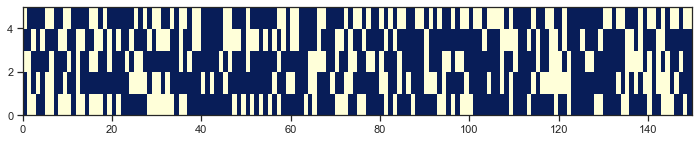

In [10]:
# И визуализируем (синим цветом показаны данные, которые попали в обучающую выборку)
fig, ax = plt.subplots(figsize=(12,2))
ax.pcolor(bin_array, cmap='YlGnBu')
plt.show()

In [11]:
# Оценим Out-of-bag error, теоретическое значение 37%
for i in range(5):
    cur_data = bin_array[i]
    len_cur_data = len(cur_data)
    sum_cur_data = sum(cur_data)
    (len(bin_array[0]) - sum(bin_array[0])) / len(bin_array[0])
    oob_i = (len_cur_data - sum_cur_data) / len_cur_data
    print('Для модели № {} размер OOB составляет {}%'.format(i+1, round(oob_i, 4)*100.0))

Для модели № 1 размер OOB составляет 38.0%
Для модели № 2 размер OOB составляет 35.33%
Для модели № 3 размер OOB составляет 33.33%
Для модели № 4 размер OOB составляет 36.67%
Для модели № 5 размер OOB составляет 42.67%


In [12]:
# Out-of-bag error, возвращаемый классификатором
bc1.oob_score_, 1-bc1.oob_score_

(0.6933333333333334, 0.30666666666666664)

In [13]:
# Параметр oob_decision_function_ возвращает вероятности 
# принадлежности объекта к классам на основе oob
# В данном примере три класса, 
# значения nan могут возвращаться в случае маленькой выборки
bc1.oob_decision_function_[55:70]

array([[0.        , 0.        , 1.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 0.33333333, 0.66666667],
       [0.        , 0.5       , 0.5       ],
       [0.        , 1.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.5       , 0.5       ],
       [       nan,        nan,        nan],
       [0.        , 0.5       , 0.5       ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.83333333, 0.16666667],
       [0.        , 1.        , 0.        ],
       [0.        , 0.25      , 0.75      ],
       [       nan,        nan,        nan],
       [0.        , 0.        , 1.        ]])

### Визуализация результатов классификации

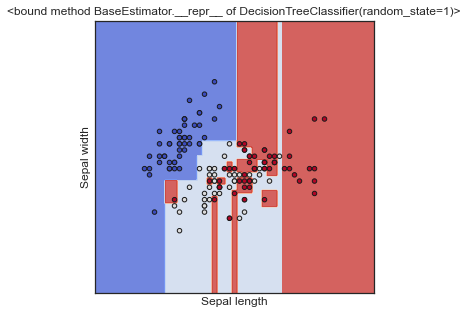

In [15]:
plot_cl(DecisionTreeClassifier(random_state=1))

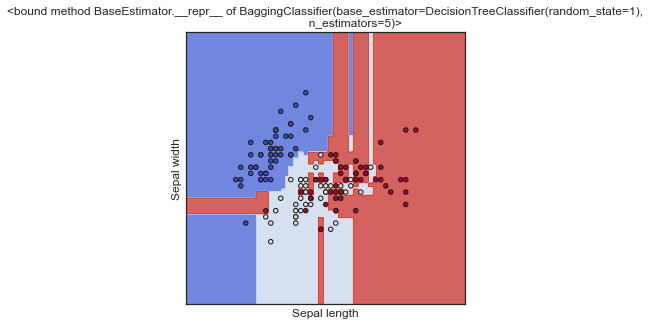

In [16]:
plot_cl(BaggingClassifier(DecisionTreeClassifier(random_state=1), n_estimators=5))

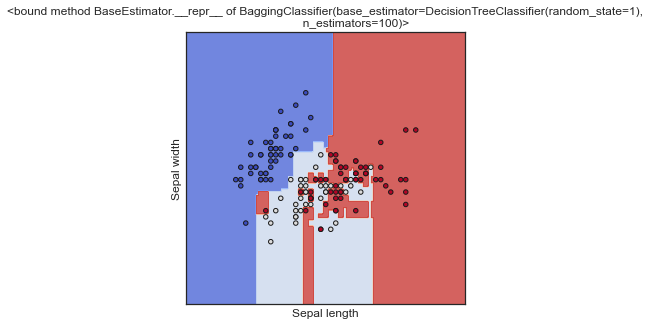

In [17]:
plot_cl(BaggingClassifier(DecisionTreeClassifier(random_state=1), n_estimators=100))

#### Алгоритм AdaBoost

In [18]:
# Обучим классификатор на 5 деревьях
ab1 = AdaBoostClassifier(n_estimators=5, algorithm='SAMME', random_state=10)
ab1.fit(iris_X, iris_y)

AdaBoostClassifier(algorithm='SAMME', n_estimators=5, random_state=10)

In [19]:
ab1.estimator_weights_

array([1.21109027, 1.71357397, 1.35360531, 1.24138009, 0.83110679])

In [20]:
df1 = ab1.decision_function(iris_X)
df1.shape

(150, 3)

In [21]:
df1[:10]

array([[0.67366299, 0.32633701, 0.        ],
       [0.40384096, 0.59615904, 0.        ],
       [0.5993106 , 0.4006894 , 0.        ],
       [0.5993106 , 0.4006894 , 0.        ],
       [0.67366299, 0.32633701, 0.        ],
       [0.67366299, 0.32633701, 0.        ],
       [0.86913263, 0.13086737, 0.        ],
       [0.67366299, 0.32633701, 0.        ],
       [0.5993106 , 0.4006894 , 0.        ],
       [0.40384096, 0.59615904, 0.        ]])

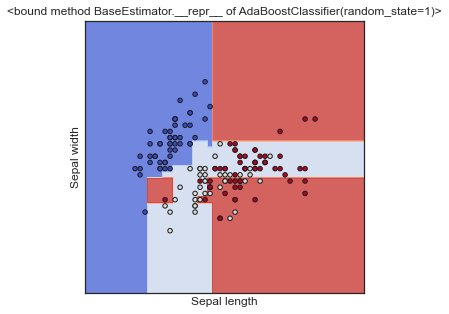

In [22]:
# Результаты классификации
plot_cl(AdaBoostClassifier(random_state=1))